<a href="https://colab.research.google.com/github/bbung9704/Financial_Engineering_Final/blob/main/Deep_Hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [ ]:
S0 = 1
K = 1
T = 30/365
r = 0.05
sig = 0.2
sig2 = sig**2

M = 5000
N = 100

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
def bs_floating(S, Sarg, r, sig, call=True, T=30/365 - (N-1)*dt):
  sig2 = sig**2
  St = S[:,-1]
  St = np.expand_dims(St, 1)

  if call:
    d1 = (np.log(St/Sarg)+(r+0.5*sig2)*(T))/(sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)
    d3 = d1 - 2*r*np.sqrt(T)/sig

    cost = St * norm.cdf(d1)
    cost += -Sarg * np.exp(-r*T) * norm.cdf(d2)
    cost += -St*sig2/(2*r) * (norm.cdf(-d1) - np.exp(-r*T) * ((Sarg/St)**(2*r/sig2)) * norm.cdf(-d3))

  else:
    d1 = (np.log(St/Sarg)+(r+0.5*sig2)*(T))/(sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)
    d3 = d1 - 2*r*np.sqrt(T)/sig

    cost = -St * norm.cdf(-d1)
    cost += Sarg*np.exp(-r*T) * norm.cdf(-d2)
    cost += St*sig2/(2*r) * (norm.cdf(d1) - np.exp(-r*T) * ((Sarg/St)**(2*r/sig)) * norm.cdf(d3))

  return cost

def priceGenerator(M, N):
  S0 = 1
  K = 1
  T = 30/365
  r = 0.05
  sig = 0.2
  dt = T/N
  rdt = r*dt
  sigsdt = sig * np.sqrt(dt)
  S = np.empty([M,N+1])
  Smin = np.empty([M,1])
  rv = np.random.normal(r*dt,sigsdt,[M,N])

  Smin = np.zeros([len(S[:,-1]),1])
  Smax = np.zeros([len(S[:,-1]),1])

  for i in range(M):
    S[i,0] = S0
    Smin[i,0] = S0
    Smax[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])
        if S[i,j+1] < Smin[i,0]:
          Smin[i,0] = S[i,j+1]
        if S[i,j+1] > Smax[i,0]:
          Smax[i,0] = S[i,j+1]

  return S, Smin, Smax

# Black-Scholes formula for lookback option
def FloatingFormula(M, call=True):
  Smin = min(S[M,:])
  Smax = max(S[M,:])
  St = S[M,(N-1)]

  # call option
  if call:
    d1 = (np.log(St/Smin)+(r+0.5*sig2)*(T-(N-1)*dt))/(sig*np.sqrt(T-(N-1)*dt))
    d2 = d1 - sig*np.sqrt(T-(N-1)*dt)
    d3 = d1 - 2*r*np.sqrt(T-(N-1)*dt)/sig
    cost = St * norm.cdf(d1)
    cost += -Smin * np.exp(-r*(T-(N-1)*dt)) * norm.cdf(d2)
    cost += -St*sig2/(2*r) * (norm.cdf(-d1) - np.exp(-r*(T-(N-1)*dt)) * ((Smin/St)**(2*r/sig2)) * norm.cdf(-d3))

  # put option
  else:
    d1 = (np.log(St/Smax)+(r+0.5*sig2)*(T-(N-1)*dt))/(sig*np.sqrt(T-(N-1)*dt))
    d2 = d1 - sig*np.sqrt(T-(N-1)*dt)
    d3 = d1 - 2*r*np.sqrt(T-(N-1)*dt)/sig
    cost = -St * norm.cdf(-d1)
    cost += Smax * np.exp(-r*(T-(N-1)*dt)) * norm.cdf(-d2)
    cost += St*sig2/(2*r) * (norm.cdf(d1) - np.exp(-r*(T-(N-1)*dt))*((Smax/St)**(2*r/sig2))*norm.cdf(d3))

  return cost

# Find payoff of floting strike lookback option
def FloatingPayoff(M, call=True):
  if call:
    minimum = min(S[M,:])
    payoff = S[M,N] - minimum
  else:
    maximum = max(S[M,:])
    payoff = maximum - S[M,N]
  
  return payoff

def FloatingSimulation(M):
  hedge = 0
  cost = 0
  k = sig2/(2*r)
  
  Smin = S[M,0]
  for j in range(N):
    e = np.exp(-r*(T-j*dt))
  
    if Smin > S[M,j]:
      Smin = S[M,j]

    d1 = (np.log(S[M,j]/Smin)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
    d3 = d1 - 2*r*np.sqrt(T-j*dt)/sig
    
    delta = norm.cdf(d1)
    delta += -k*norm.cdf(-d1) + k*S[M,j]*norm.pdf(-d1)/(sig*np.sqrt(T-j*dt)*S[M,j])
    delta += k*e*(Smin**(1/k))*(1-1/k)*(S[M,j]**(-1/k))*norm.cdf(-d3) - k*e*(Smin**(1/k))*(S[M,j]**(1-1/k))*norm.pdf(-d3)/(sig*np.sqrt(T-j*dt)*S[M,j])
    
    cost = cost + (hedge-delta) * S[M,j]
    hedge = delta

  cost = cost + (hedge-1)*S[M,j] + Smin

  return cost

# Find payoff of fixed strike lookback option
def FixedPayoff(M, K, call=True):
  if call:
    maximum = max(S[i,:])
    payoff = max(maximum-K, 0)
  else:
    minimum = min(S[i,:])
    payoff = max(K-minimum, 0)
  
  return payoff

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

In [ ]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")
# # call option
# min_price = tf.keras.layers.Input(shape=(1,), name="min_price")
# put option
max_price = tf.keras.layers.Input(shape=(1,), name="max_price")

# # call option
# my_input = my_input + [premium] + [hedge_cost] + [min_price] + [price]
# put option
my_input = my_input + [premium] + [hedge_cost] + [max_price] + [price]

for j in range(N):    
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

# # call option
# price_gap = tf.keras.layers.Subtract(name="price-min_price")([price, min_price])

# put option
price_gap = price_gap = tf.keras.layers.Subtract(name="max_price-price")([max_price, price])

payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x,0), name='payoff')(price_gap)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

In [ ]:
S, Smin, Smax = priceGenerator(M, N)

In [ ]:
BS_call = []
BS_put = []
float_call = []
float_put = []
fix_call = []
fix_put = []
ans_call = []
ans_put = []

for i in range(M):
  BS_call.append(FloatingFormula(i, call=True))
  BS_put.append(FloatingFormula(i, call=False))
  float_call.append(FloatingPayoff(i, call=True))
  float_put.append(FloatingPayoff(i, call=False))
  fix_call.append(FixedPayoff(i, 1, call=True))
  fix_put.append(FixedPayoff(i, 1, call=False))
  ans_call.append(BS_call[i]-float_call[i])
  ans_put.append(BS_put[i]-float_put[i])

print('BS call Mean: ', np.mean(BS_call))
print('Floating call Mean: ', np.mean(float_call))
print('BS put Mean: ', np.mean(BS_put))
print('Floating put Mean: ', np.mean(float_put))
print('Fixed call Mean: ', np.mean(fix_call))
print('Fixed call Mean: ', np.mean(fix_put))

BS call Mean:  0.04427915771386881
Floating call Mean:  0.04407177430166127
BS put Mean:  0.042279097123248975
Floating put Mean:  0.04181615424648568
Fixed call Mean:  0.045216821473609455
Fixed call Mean:  0.0406711070745375


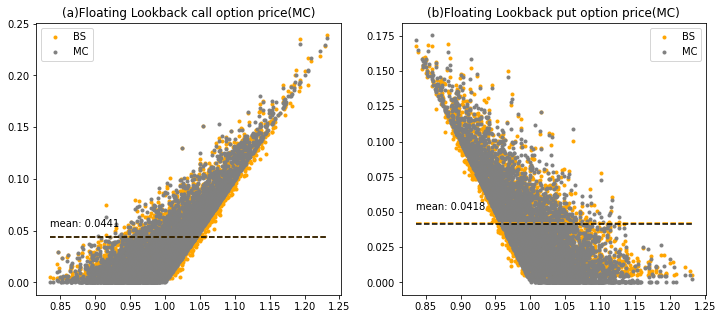

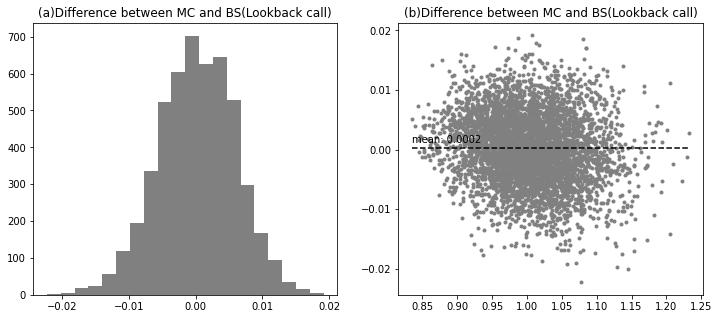

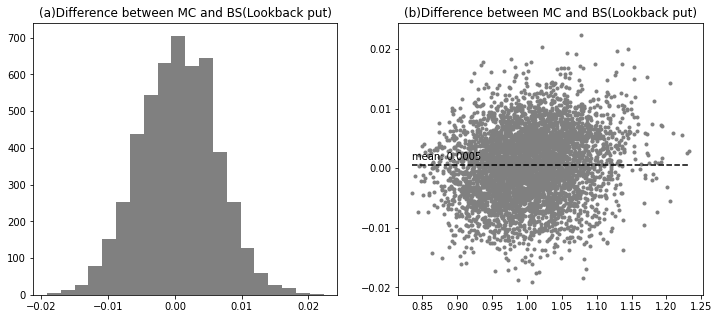

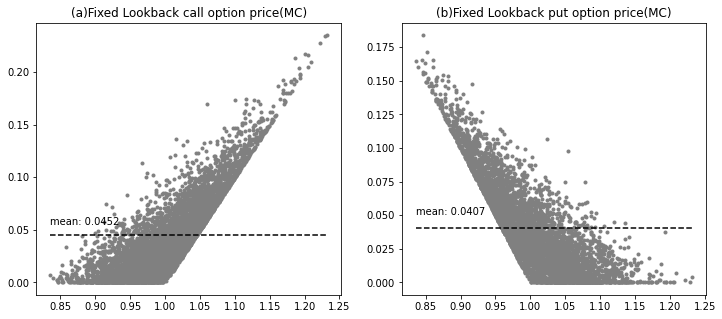

In [ ]:
# from matplotlib import lines
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(S[:,-1], BS_call, marker='.', linestyle='none', color='orange', label='BS')
plt.hlines(np.mean(BS_call), min(S[:,-1]), max(S[:,-1]),linestyle='dashed', color='orange', zorder=10000)
plt.plot(S[:,-1], float_call, marker='.', linestyle='none', color='gray', label='MC')
plt.hlines(np.mean(float_call), min(S[:,-1]), max(S[:,-1]),linestyle='dashed', color='black', zorder=10001)
plt.text(min(S[:,-1]), np.mean(float_call)+0.01, 'mean: %.4f'%np.mean(float_call), color='black')
plt.title('(a)Floating Lookback call option price(MC)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(S[:,-1], BS_put, marker='.', linestyle='none', color='orange', label='BS')
plt.hlines(np.mean(BS_put), min(S[:,-1]), max(S[:,-1]),linestyle='dashed', color='orange', zorder=10000)
plt.plot(S[:,-1], float_put, marker='.', linestyle='none', color='gray', label='MC')
plt.hlines(np.mean(float_put), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(float_put)+0.01, 'mean: %.4f'%np.mean(float_put), color='black')
plt.title('(b)Floating Lookback put option price(MC)')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(ans_call, bins=20, color='gray')
plt.title('(a)Difference between MC and BS(Lookback call)')

plt.subplot(1,2,2)
plt.plot(S[:,-1], ans_call, marker='.', linestyle='none', color='gray')
plt.hlines(np.mean(ans_call), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(ans_call)+0.001, 'mean: %.4f'%np.mean(ans_call), color='black')
plt.title('(b)Difference between MC and BS(Lookback call)')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(ans_put, bins=20, color='gray')
plt.title('(a)Difference between MC and BS(Lookback put)')

plt.subplot(1,2,2)
plt.plot(S[:,-1], ans_put, marker='.', linestyle='none', color='gray')
plt.hlines(np.mean(ans_put), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(ans_put)+0.001, 'mean: %.4f'%np.mean(ans_put), color='black')
plt.title('(b)Difference between MC and BS(Lookback put)')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(S[:,-1], fix_call, marker='.', linestyle='none', color='gray')
plt.hlines(np.mean(fix_call), min(S[:,-1]), max(S[:,-1]),linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(fix_call)+0.01, 'mean: %.4f'%np.mean(fix_call), color='black')
plt.title('(a)Fixed Lookback call option price(MC)')

plt.subplot(1,2,2)
plt.plot(S[:,-1], fix_put, marker='.', linestyle='none', color='gray')
plt.hlines(np.mean(fix_put), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(fix_put)+0.01, 'mean: %.4f'%np.mean(fix_put), color='black')
plt.title('(b)Fixed Lookback put option price(MC)')
plt.show()

In [ ]:
premium = bs_floating(S, Smax, r, sig, call=True) * np.ones([M,1])
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium]+[cost]+[Smax]+[SS]
y = np.zeros([M,1])

In [ ]:
# model.compile(loss='mse', optimizer='adam')

In [ ]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, batch_size=32, epochs=0, verbose=True, validation_split=0.2)
pred0 = model.predict(x)

157/157 [==============================] - 10s 19ms/step


In [ ]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, batch_size=32, epochs=25, verbose=True, validation_split=0.2)
pred25 = model.predict(x)

Epoch 1/25
125/125 [==============================] - 68s 131ms/step - loss: 5.0820e-04 - val_loss: 3.9521e-05
Epoch 2/25
125/125 [==============================] - 11s 85ms/step - loss: 5.7952e-05 - val_loss: 3.3123e-05
Epoch 3/25
125/125 [==============================] - 9s 71ms/step - loss: 5.2207e-05 - val_loss: 3.7868e-05
Epoch 4/25
125/125 [==============================] - 9s 71ms/step - loss: 9.6006e-05 - val_loss: 1.1181e-04
Epoch 5/25
125/125 [==============================] - 9s 72ms/step - loss: 1.4028e-04 - val_loss: 3.4612e-04
Epoch 6/25
125/125 [==============================] - 9s 72ms/step - loss: 9.9024e-05 - val_loss: 3.7196e-04
Epoch 7/25
125/125 [==============================] - 9s 72ms/step - loss: 7.8994e-05 - val_loss: 3.4944e-04
Epoch 8/25
125/125 [==============================] - 9s 71ms/step - loss: 6.4410e-05 - val_loss: 3.3164e-04
Epoch 9/25
125/125 [==============================] - 9s 71ms/step - loss: 7.2699e-05 - val_loss: 6.4239e-04
Epoch 10/25
125/

In [ ]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, batch_size=32, epochs=50, verbose=True, validation_split=0.2)
pred50 = model.predict(x)

Epoch 1/50
125/125 [==============================] - 68s 130ms/step - loss: 5.7730e-05 - val_loss: 0.0011
Epoch 2/50
125/125 [==============================] - 9s 72ms/step - loss: 7.9314e-05 - val_loss: 6.7440e-04
Epoch 3/50
125/125 [==============================] - 9s 71ms/step - loss: 6.7142e-05 - val_loss: 6.0897e-04
Epoch 4/50
125/125 [==============================] - 9s 75ms/step - loss: 7.3361e-05 - val_loss: 5.4927e-04
Epoch 5/50
125/125 [==============================] - 9s 73ms/step - loss: 4.3857e-05 - val_loss: 3.0897e-04
Epoch 6/50
125/125 [==============================] - 10s 82ms/step - loss: 3.9094e-05 - val_loss: 1.9019e-04
Epoch 7/50
125/125 [==============================] - 9s 73ms/step - loss: 3.7089e-05 - val_loss: 1.9603e-04
Epoch 8/50
125/125 [==============================] - 9s 72ms/step - loss: 5.5548e-05 - val_loss: 3.4734e-04
Epoch 9/50
125/125 [==============================] - 9s 72ms/step - loss: 4.1446e-05 - val_loss: 2.2165e-04
Epoch 10/50
125/125 

In [ ]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, batch_size=32, epochs=100, verbose=True, validation_split=0.2)
pred100 = model.predict(x)

Epoch 1/100
125/125 [==============================] - 71s 142ms/step - loss: 1.6845e-05 - val_loss: 5.5921e-05
Epoch 2/100
125/125 [==============================] - 9s 72ms/step - loss: 1.7859e-05 - val_loss: 1.5887e-04
Epoch 3/100
125/125 [==============================] - 9s 73ms/step - loss: 1.8607e-05 - val_loss: 1.0799e-04
Epoch 4/100
125/125 [==============================] - 9s 72ms/step - loss: 2.0965e-05 - val_loss: 8.5176e-05
Epoch 5/100
125/125 [==============================] - 9s 74ms/step - loss: 1.9740e-05 - val_loss: 1.0227e-04
Epoch 6/100
125/125 [==============================] - 9s 72ms/step - loss: 1.8701e-05 - val_loss: 7.5852e-05
Epoch 7/100
125/125 [==============================] - 9s 73ms/step - loss: 1.7242e-05 - val_loss: 8.6327e-05
Epoch 8/100
125/125 [==============================] - 9s 74ms/step - loss: 1.6122e-05 - val_loss: 5.6636e-05
Epoch 9/100
125/125 [==============================] - 9s 73ms/step - loss: 1.5570e-05 - val_loss: 7.1861e-05
Epoch 10

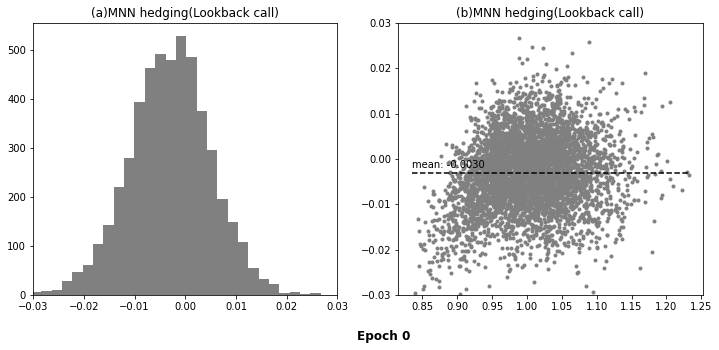

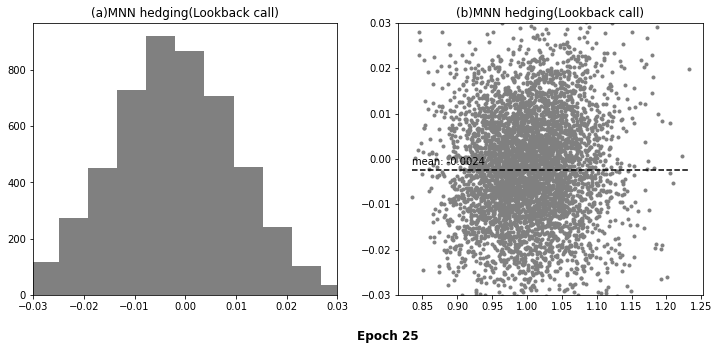

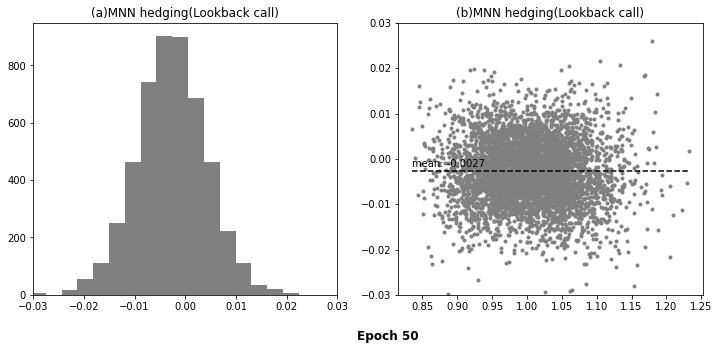

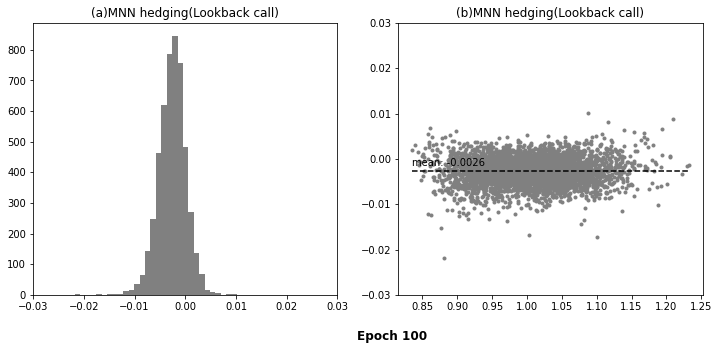

In [ ]:
# epoch 0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(pred0, bins=30, color='gray')
plt.xlim(-0.03, 0.03)
plt.title('(a)MNN hedging(Lookback call)')
plt.subplot(1,2,2)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], pred0, marker = ".", linestyle='none', color='gray')
plt.hlines(np.mean(pred0), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred0)+0.001, 'mean: %.4f'%np.mean(pred0), color='black')
plt.title('(b)MNN hedging(Lookback call)')
plt.figtext(0.5, 0, 'Epoch 0', fontsize='large', fontweight='bold')
plt.show()

# epoch 25
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(pred25, bins=30, color='gray')
plt.xlim(-0.03, 0.03)
plt.title('(a)MNN hedging(Lookback call)')
plt.subplot(1,2,2)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], pred25, marker = ".", linestyle='none', color='gray')
plt.hlines(np.mean(pred25), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred25)+0.001, 'mean: %.4f'%np.mean(pred25), color='black')
plt.title('(b)MNN hedging(Lookback call)')
plt.figtext(0.5, 0, 'Epoch 25', fontsize='large', fontweight='bold')
plt.show()

# epoch 50
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(pred50, bins=30, color='gray')
plt.xlim(-0.03, 0.03)
plt.title('(a)MNN hedging(Lookback call)')
plt.subplot(1,2,2)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], pred50, marker = ".", linestyle='none', color='gray')
plt.hlines(np.mean(pred50), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred50)+0.001, 'mean: %.4f'%np.mean(pred50), color='black')
plt.title('(b)MNN hedging(Lookback call)')
plt.figtext(0.5, 0, 'Epoch 50', fontsize='large', fontweight='bold')
plt.show()

# epoch 100
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(pred100, bins=30, color='gray')
plt.xlim(-0.03, 0.03)
plt.title('(a)MNN hedging(Lookback call)')
plt.subplot(1,2,2)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], pred100, marker = ".", linestyle='none', color='gray')
plt.hlines(np.mean(pred100), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred100)+0.001, 'mean: %.4f'%np.mean(pred100), color='black')
plt.title('(b)MNN hedging(Lookback call)')
plt.figtext(0.5, 0, 'Epoch 100', fontsize='large', fontweight='bold')
plt.show()

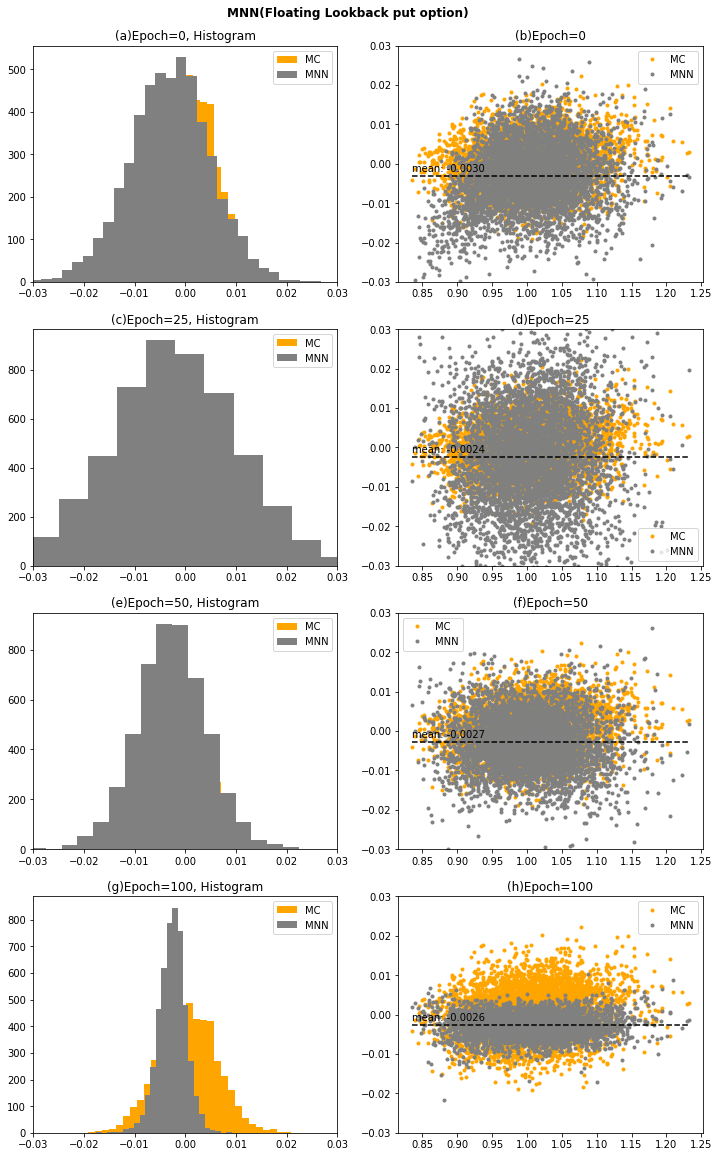

In [ ]:
# put option
# epoch 0
plt.figure(figsize=(12,20))
plt.figtext(0.35, 0.9, 'MNN(Floating Lookback put option)', fontsize='large', fontweight='bold')
plt.subplot(4,2,1)
plt.hist(ans_put, bins=30, color='orange', label='MC')
plt.hist(pred0, bins=30, color='gray', label='MNN')
plt.xlim(-0.03, 0.03)
plt.legend()
plt.title('(a)Epoch=0, Histogram')
plt.subplot(4,2,2)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], ans_put, marker='.', linestyle='none', color='orange', label='MC')
plt.plot(S[:,-1], pred0, marker = ".", linestyle='none', color='gray', label='MNN')
plt.hlines(np.mean(pred0), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred0)+0.001, 'mean: %.4f'%np.mean(pred0), color='black')
plt.title('(b)Epoch=0')
plt.legend()
# plt.show()

# epoch 25
# plt.figure(figsize=(12,5))
plt.subplot(4,2,3)
plt.hist(ans_put, bins=30, color='orange', label='MC')
plt.hist(pred25, bins=30, color='gray', label='MNN')
plt.xlim(-0.03, 0.03)
plt.legend()
plt.title('(c)Epoch=25, Histogram')
plt.subplot(4,2,4)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], ans_put, marker='.', linestyle='none', color='orange', label='MC')
plt.plot(S[:,-1], pred25, marker = ".", linestyle='none', color='gray', label='MNN')
plt.hlines(np.mean(pred25), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred25)+0.001, 'mean: %.4f'%np.mean(pred25), color='black')
plt.title('(d)Epoch=25')
plt.legend()
# plt.show()

# epoch 50
# plt.figure(figsize=(12,5))
plt.subplot(4,2,5)
plt.hist(ans_put, bins=30, color='orange', label='MC')
plt.hist(pred50, bins=30, color='gray', label='MNN')
plt.xlim(-0.03, 0.03)
plt.legend()
plt.title('(e)Epoch=50, Histogram')
plt.subplot(4,2,6)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], ans_put, marker='.', linestyle='none', color='orange', label='MC')
plt.plot(S[:,-1], pred50, marker = ".", linestyle='none', color='gray', label='MNN')
plt.hlines(np.mean(pred50), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred50)+0.001, 'mean: %.4f'%np.mean(pred50), color='black')
plt.title('(f)Epoch=50')
plt.legend()
# plt.show()

# epoch 100
# plt.figure(figsize=(12,5))
plt.subplot(4,2,7)
plt.hist(ans_put, bins=30, color='orange', label='MC')
plt.hist(pred100, bins=30, color='gray', label='MNN')
plt.xlim(-0.03, 0.03)
plt.legend()
plt.title('(g)Epoch=100, Histogram')
plt.subplot(4,2,8)
plt.ylim(-0.03, 0.03)
plt.plot(S[:,-1], ans_put, marker='.', linestyle='none', color='orange', label='MC')
plt.plot(S[:,-1], pred100, marker = ".", linestyle='none', color='gray', label='MNN')
plt.hlines(np.mean(pred100), min(S[:,-1]), max(S[:,-1]), linestyle='dashed', color='black', zorder=10000)
plt.text(min(S[:,-1]), np.mean(pred100)+0.001, 'mean: %.4f'%np.mean(pred100), color='black')
plt.title('(h)Epoch=100')
plt.legend()
plt.show()